## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Standard libraries loaded")

✓ Standard libraries loaded


In [2]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, '../')

# Import project modules
from src.data_loader import load_wine_quality, preprocess_data, split_data
from src.ensemble import ScalingEnsemble
from src.complex_baselines import ComplexBaseline, train_random_forest, train_gradient_boosting

print("✓ Project modules loaded")

✓ Project modules loaded


In [3]:
# Create results directories
RESULTS_DIR = Path('../results/ensemble')
FIGURES_DIR = RESULTS_DIR / 'figures'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Figures directory: {FIGURES_DIR}")

✓ Results directory: ../results/ensemble
✓ Figures directory: ../results/ensemble/figures


In [4]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"✓ Random seed set to {RANDOM_STATE}")

✓ Random seed set to 42


## 2. Load Wine Quality Dataset

In [5]:
# Load the wine quality dataset
print("Loading Wine Quality dataset...")
X, y = load_wine_quality()
feature_names = X.columns.tolist()

print(f"\n✓ Dataset loaded successfully!")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Feature names: {feature_names}")

Loading Wine Quality dataset...
Wine Quality Dataset loaded: 6497 samples, 12 features
Class distribution: {0: 5220, 1: 1277}

✓ Dataset loaded successfully!
  Samples: 6497
  Features: 12
  Feature names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type']


In [6]:
# Preprocess data (handle missing values if any)
X_processed, y_processed = preprocess_data(X, y)

print(f"\nClass distribution:")
unique, counts = np.unique(y_processed, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_processed)*100:.1f}%)")


Class distribution:
  Class 0: 5220 (80.3%)
  Class 1: 1277 (19.7%)


In [7]:
# Split into train/test sets
X_train, X_test, y_train, y_test = split_data(
    X, y_processed, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"\n✓ Data split complete:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")


Data split: 5197 train, 1300 test samples
Train class distribution: {0: 4176, 1: 1021}
Test class distribution: {0: 1044, 1: 256}

✓ Data split complete:
  Training samples: 5197
  Test samples: 1300


## 3. Implement Uniform Ensemble

### 3.1 Initialize Ensemble with Default Scalers

In [8]:
# Create scaling ensemble with uniform weights
ensemble = ScalingEnsemble(
    weights='uniform',
    cv=5,
    random_state=RANDOM_STATE,
    verbose=True
)

# Initialize scalers to get the names
ensemble._initialize_scalers()

print("Uniform Ensemble initialized")
print(f"  Scalers: {[name for name, _ in ensemble.scalers]}")
print(f"  Base estimator: LogisticRegressionCV")
print(f"  Weighting: Uniform (1/{len(ensemble.scalers)} each)")
print(f"  CV folds: {ensemble.cv}")

Uniform Ensemble initialized
  Scalers: ['standard', 'minmax', 'robust', 'maxabs']
  Base estimator: LogisticRegressionCV
  Weighting: Uniform (1/4 each)
  CV folds: 5


### 3.2 Train Uniform Ensemble

In [9]:
# Train the ensemble
print("\nTraining uniform ensemble...")
print("="*80)

start_time = time.time()
ensemble.fit(X_train, y_train)
training_time = time.time() - start_time

print("="*80)
print(f"\n✓ Ensemble training complete in {training_time:.3f} seconds")
print(f"  Average time per model: {training_time/len(ensemble.scalers_):.3f}s")


Training uniform ensemble...

Training Scaling Ensemble with 4 models

Training with standard scaler...
  ✓ Completed in 1.328s
    Best C: 1.0000
    CV Score: 0.8061

Training with minmax scaler...
  ✓ Completed in 1.029s
    Best C: 100.0000
    CV Score: 0.7836

Training with robust scaler...
  ✓ Completed in 0.947s
    Best C: 10.0000
    CV Score: 0.8048

Training with maxabs scaler...
  ✓ Completed in 0.862s
    Best C: 10.0000
    CV Score: 0.7731

Total training time: 4.166s


✓ Ensemble training complete in 4.167 seconds
  Average time per model: 1.042s


### 3.3 Evaluate Uniform Ensemble

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Get predictions
y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
y_pred = ensemble.predict(X_test)

# Calculate metrics
uniform_results = {
    'model': 'Uniform Ensemble',
    'auc_roc': roc_auc_score(y_test, y_pred_proba),
    'pr_auc': average_precision_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, y_pred),
    'training_time': training_time
}

print("\nUniform Ensemble Performance:")
print(f"  AUC-ROC: {uniform_results['auc_roc']:.4f}")
print(f"  PR AUC:  {uniform_results['pr_auc']:.4f}")
print(f"  Accuracy: {uniform_results['accuracy']:.4f}")


Uniform Ensemble Performance:
  AUC-ROC: 0.8041
  PR AUC:  0.5323
  Accuracy: 0.8246


### 3.4 Analyze Individual Member Performance

In [11]:
# Get individual member predictions
member_predictions = ensemble.get_member_predictions(X_test)

print("\nIndividual Member Performance:")
print("="*80)

member_results = []
for scaler_name, proba in member_predictions.items():
    pred = (proba[:, 1] > 0.5).astype(int)
    
    result = {
        'scaler': scaler_name,
        'auc_roc': roc_auc_score(y_test, proba[:, 1]),
        'pr_auc': average_precision_score(y_test, proba[:, 1]),
        'accuracy': accuracy_score(y_test, pred)
    }
    member_results.append(result)
    
    print(f"{scaler_name:15s} - AUC: {result['auc_roc']:.4f}, "
          f"PR AUC: {result['pr_auc']:.4f}, Acc: {result['accuracy']:.4f}")

member_results_df = pd.DataFrame(member_results)
print("="*80)


Individual Member Performance:
standard        - AUC: 0.8048, PR AUC: 0.5248, Acc: 0.8231
minmax          - AUC: 0.8048, PR AUC: 0.5249, Acc: 0.8231
robust          - AUC: 0.8049, PR AUC: 0.5257, Acc: 0.8223
maxabs          - AUC: 0.8003, PR AUC: 0.5277, Acc: 0.8254


### 3.5 Compute Ensemble Diversity Metrics

In [12]:
# Compute diversity metrics
diversity_metrics = ensemble.analyze_diversity(X_test)

print("\nEnsemble Diversity Metrics:")
print("="*80)

# Get correlation matrix
corr_matrix = diversity_metrics['pairwise_correlations']
# Average correlation (excluding diagonal)
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
avg_correlation = corr_matrix[mask].mean()

# Get agreement matrix
agreement_matrix = diversity_metrics['agreement_matrix']
# Average disagreement (excluding diagonal)
avg_disagreement = 1 - agreement_matrix[mask].mean()

print(f"  Average pairwise correlation: {avg_correlation:.4f}")
print(f"  Average disagreement: {avg_disagreement:.4f}")
print(f"  Average prediction variance: {diversity_metrics['prediction_variance'].mean():.4f}")

print("\nPairwise Correlations:")
scaler_names = diversity_metrics['scaler_names']
corr_df = pd.DataFrame(corr_matrix, index=scaler_names, columns=scaler_names)
print(corr_df.round(4))
print("="*80)


Ensemble Diversity Metrics:
  Average pairwise correlation: 0.9905
  Average disagreement: 0.0123
  Average prediction variance: 0.0002

Pairwise Correlations:
          standard  minmax  robust  maxabs
standard    1.0000  0.9997  0.9999  0.9810
minmax      0.9997  1.0000  0.9993  0.9848
robust      0.9999  0.9993  1.0000  0.9784
maxabs      0.9810  0.9848  0.9784  1.0000


## 4. Complex Baseline Models

### 4.1 Random Forest Baseline

In [13]:
# Train Random Forest with hyperparameter tuning
print("\nTraining Random Forest baseline...")
print("="*80)

rf_baseline = ComplexBaseline(
    model_type='random_forest',
    cv=5,
    random_state=RANDOM_STATE,
    verbose=True
)

start_time = time.time()
rf_baseline.fit(X_train, y_train)
rf_training_time = time.time() - start_time

print("="*80)
print(f"\n✓ Random Forest training complete in {rf_training_time:.3f} seconds")
print(f"  Best parameters: {rf_baseline.best_params_}")


Training Random Forest baseline...

Training Random Forest
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
CV folds: 5
Scoring: roc_auc

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Training completed in 13.916s
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9100


✓ Random Forest training complete in 13.916 seconds
  Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [14]:
# Evaluate Random Forest
y_pred_proba_rf = rf_baseline.predict_proba(X_test)[:, 1]
y_pred_rf = rf_baseline.predict(X_test)

rf_results = {
    'model': 'Random Forest',
    'auc_roc': roc_auc_score(y_test, y_pred_proba_rf),
    'pr_auc': average_precision_score(y_test, y_pred_proba_rf),
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'training_time': rf_training_time,
    'best_params': str(rf_baseline.best_params_)
}

print("\nRandom Forest Performance:")
print(f"  AUC-ROC: {rf_results['auc_roc']:.4f}")
print(f"  PR AUC:  {rf_results['pr_auc']:.4f}")
print(f"  Accuracy: {rf_results['accuracy']:.4f}")


Random Forest Performance:
  AUC-ROC: 0.9164
  PR AUC:  0.7861
  Accuracy: 0.8862


### 4.2 Gradient Boosting Baseline

In [15]:
# Train Gradient Boosting with hyperparameter tuning
print("\nTraining Gradient Boosting baseline...")
print("="*80)

gb_baseline = ComplexBaseline(
    model_type='gradient_boosting',
    cv=5,
    random_state=RANDOM_STATE,
    verbose=True
)

start_time = time.time()
gb_baseline.fit(X_train, y_train)
gb_training_time = time.time() - start_time

print("="*80)
print(f"\n✓ Gradient Boosting training complete in {gb_training_time:.3f} seconds")
print(f"  Best parameters: {gb_baseline.best_params_}")


Training Gradient Boosting baseline...

Training Gradient Boosting
Parameter grid: {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'min_samples_split': [2, 5], 'subsample': [0.8, 1.0]}
CV folds: 5
Scoring: roc_auc

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Training completed in 10.715s
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.8875


✓ Gradient Boosting training complete in 10.716 seconds
  Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}


In [16]:
# Evaluate Gradient Boosting
y_pred_proba_gb = gb_baseline.predict_proba(X_test)[:, 1]
y_pred_gb = gb_baseline.predict(X_test)

gb_results = {
    'model': 'Gradient Boosting',
    'auc_roc': roc_auc_score(y_test, y_pred_proba_gb),
    'pr_auc': average_precision_score(y_test, y_pred_proba_gb),
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'training_time': gb_training_time,
    'best_params': str(gb_baseline.best_params_)
}

print("\nGradient Boosting Performance:")
print(f"  AUC-ROC: {gb_results['auc_roc']:.4f}")
print(f"  PR AUC:  {gb_results['pr_auc']:.4f}")
print(f"  Accuracy: {gb_results['accuracy']:.4f}")


Gradient Boosting Performance:
  AUC-ROC: 0.8793
  PR AUC:  0.6884
  Accuracy: 0.8608


## 5. Performance Comparison

### 5.1 Create Comparison Table

In [17]:
# Combine all results
all_results = []

# Add individual scalers from ensemble
for _, row in member_results_df.iterrows():
    all_results.append({
        'model': f"Single - {row['scaler']}",
        'auc_roc': row['auc_roc'],
        'pr_auc': row['pr_auc'],
        'accuracy': row['accuracy'],
        'training_time': training_time / len(member_results_df)  # Approximate
    })

# Add ensemble
all_results.append(uniform_results)

# Add complex baselines
all_results.append(rf_results)
all_results.append(gb_results)

# Create DataFrame
comparison_df = pd.DataFrame(all_results)

print("\nPerformance Comparison:")
print("="*80)
display(comparison_df.round(4))
print("="*80)


Performance Comparison:


,model,auc_roc,pr_auc,accuracy,training_time,best_params
0,Single - standard,0.8048,0.5248,0.8231,1.0418,NaN
1,Single - minmax,0.8048,0.5249,0.8231,1.0418,NaN
2,Single - robust,0.8049,0.5257,0.8223,1.0418,NaN
3,Single - maxabs,0.8003,0.5277,0.8254,1.0418,NaN
4,Uniform Ensemble,0.8041,0.5323,0.8246,4.1673,NaN
5,Random Forest,0.9164,0.7861,0.8862,13.9163,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
6,Gradient Boosting,0.8793,0.6884,0.8608,10.7159,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa..."


In [18]:
# Identify best model for each metric
print("\nBest Model by Metric:")
print("-"*80)

for metric in ['auc_roc', 'pr_auc', 'accuracy']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"  {metric.upper():12s}: {best_model:25s} ({best_score:.4f})")

print("-"*80)


Best Model by Metric:
--------------------------------------------------------------------------------
  AUC_ROC     : Random Forest             (0.9164)
  PR_AUC      : Random Forest             (0.7861)
  ACCURACY    : Random Forest             (0.8862)
--------------------------------------------------------------------------------


### 5.2 Visualize Performance Comparison

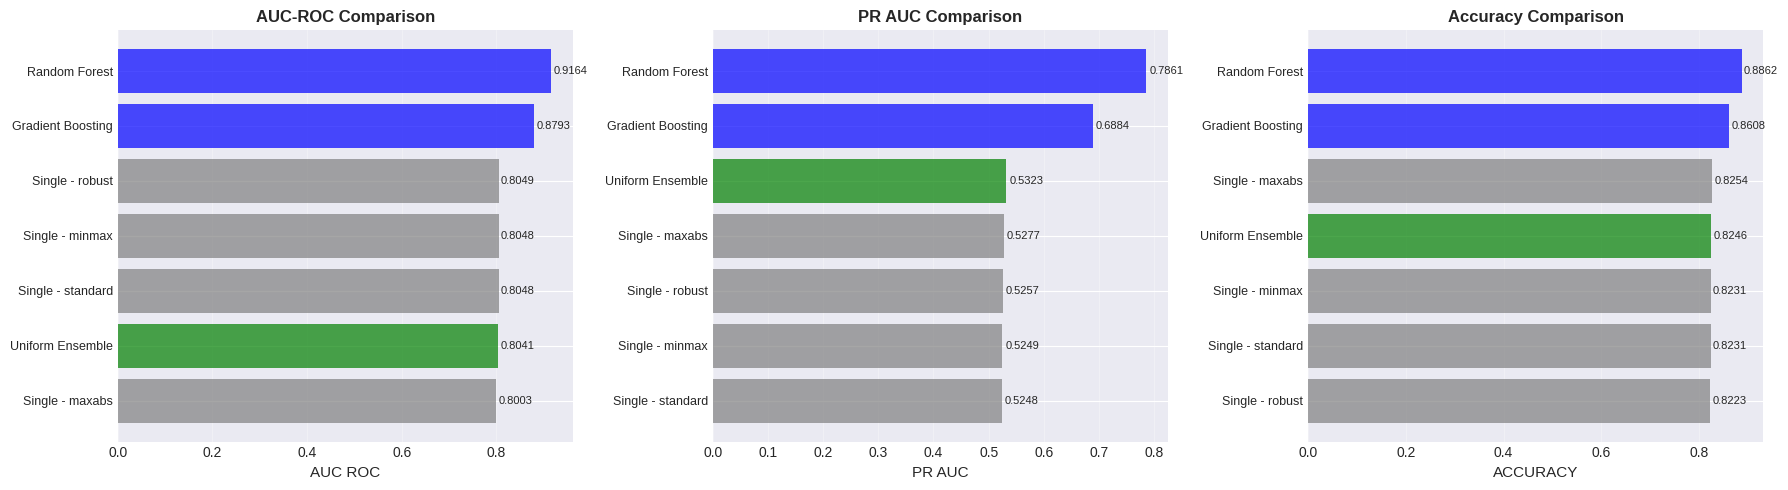


✓ Performance comparison saved to ../results/ensemble/figures/performance_comparison.png


In [19]:
# Create performance comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['auc_roc', 'pr_auc', 'accuracy']
titles = ['AUC-ROC Comparison', 'PR AUC Comparison', 'Accuracy Comparison']

for ax, metric, title in zip(axes, metrics, titles):
    # Sort by metric value
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create color map: ensemble in green, baselines in blue, singles in gray
    colors = []
    for model in sorted_df['model']:
        if 'Ensemble' in model:
            colors.append('green')
        elif 'Forest' in model or 'Boosting' in model:
            colors.append('blue')
        else:
            colors.append('gray')
    
    # Create horizontal bar chart
    ax.barh(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['model'], fontsize=9)
    ax.set_xlabel(metric.replace('_', ' ').upper(), fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.tight_layout()
save_path = FIGURES_DIR / 'performance_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Performance comparison saved to {save_path}")

### 5.3 Training Time Comparison

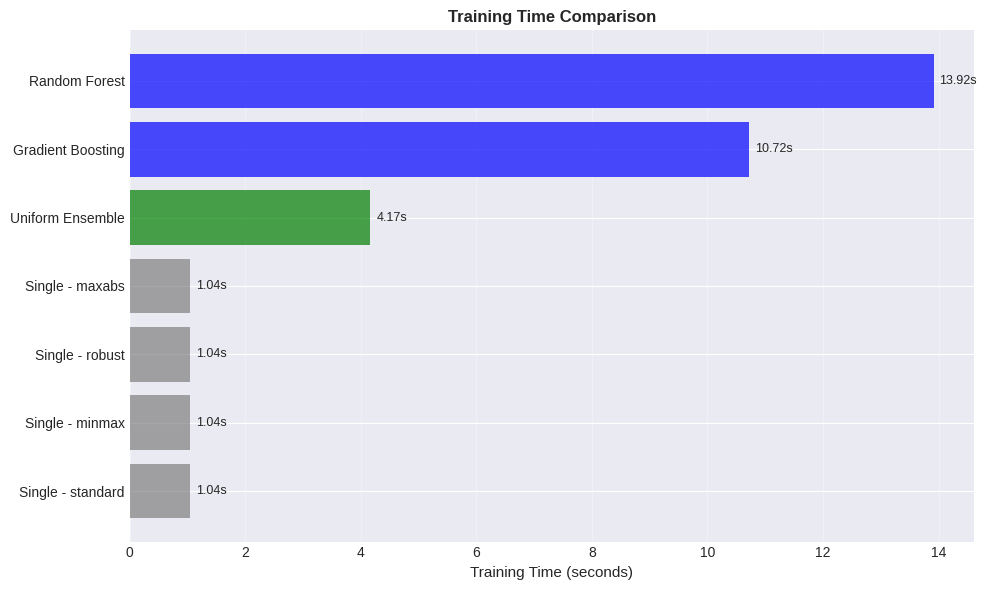

✓ Training time comparison saved to ../results/ensemble/figures/training_time_comparison.png


In [20]:
# Visualize training time comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Get models with training times
models_with_time = comparison_df[comparison_df['training_time'].notna()].copy()
models_with_time = models_with_time.sort_values('training_time', ascending=True)

colors = []
for model in models_with_time['model']:
    if 'Ensemble' in model:
        colors.append('green')
    elif 'Forest' in model or 'Boosting' in model:
        colors.append('blue')
    else:
        colors.append('gray')

ax.barh(range(len(models_with_time)), models_with_time['training_time'], 
        color=colors, alpha=0.7)
ax.set_yticks(range(len(models_with_time)))
ax.set_yticklabels(models_with_time['model'])
ax.set_xlabel('Training Time (seconds)', fontsize=11)
ax.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(models_with_time['training_time']):
    ax.text(v + 0.1, i, f'{v:.2f}s', va='center', fontsize=9)

plt.tight_layout()
save_path = FIGURES_DIR / 'training_time_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training time comparison saved to {save_path}")

### 5.4 Ensemble Diversity Visualization

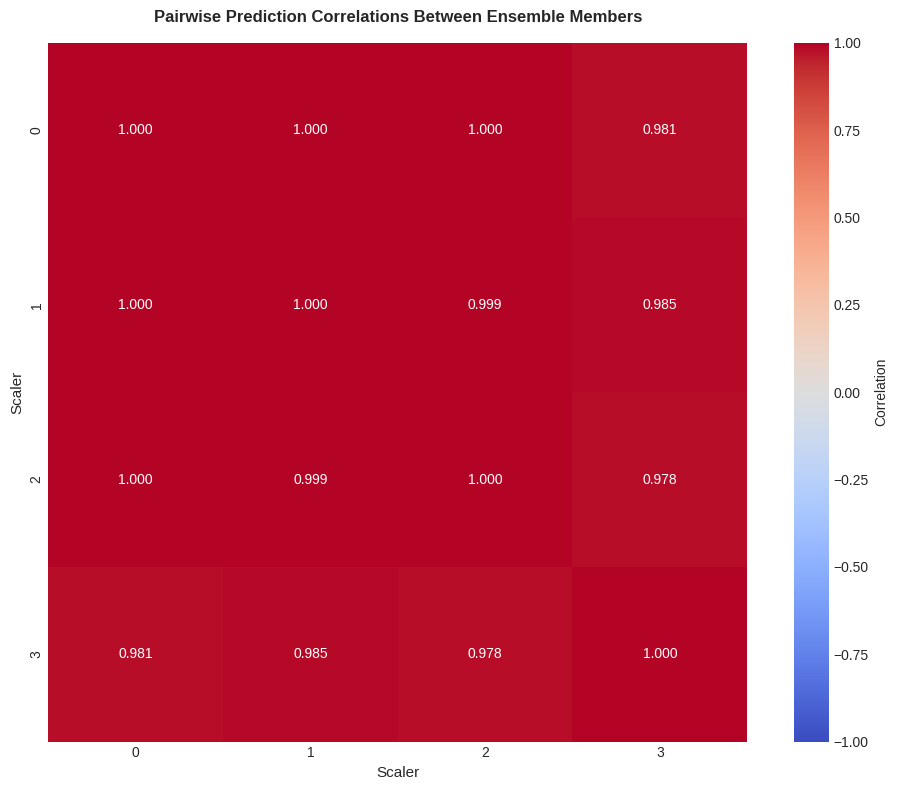

✓ Diversity heatmap saved to ../results/ensemble/figures/ensemble_diversity_heatmap.png


In [21]:
# Visualize pairwise correlations as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = pd.DataFrame(diversity_metrics['pairwise_correlations'])
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'label': 'Correlation'})

ax.set_title('Pairwise Prediction Correlations Between Ensemble Members', 
             fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Scaler', fontsize=11)
ax.set_ylabel('Scaler', fontsize=11)

plt.tight_layout()
save_path = FIGURES_DIR / 'ensemble_diversity_heatmap.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Diversity heatmap saved to {save_path}")

## 6. ROC and Precision-Recall Curves

### 6.1 ROC Curves

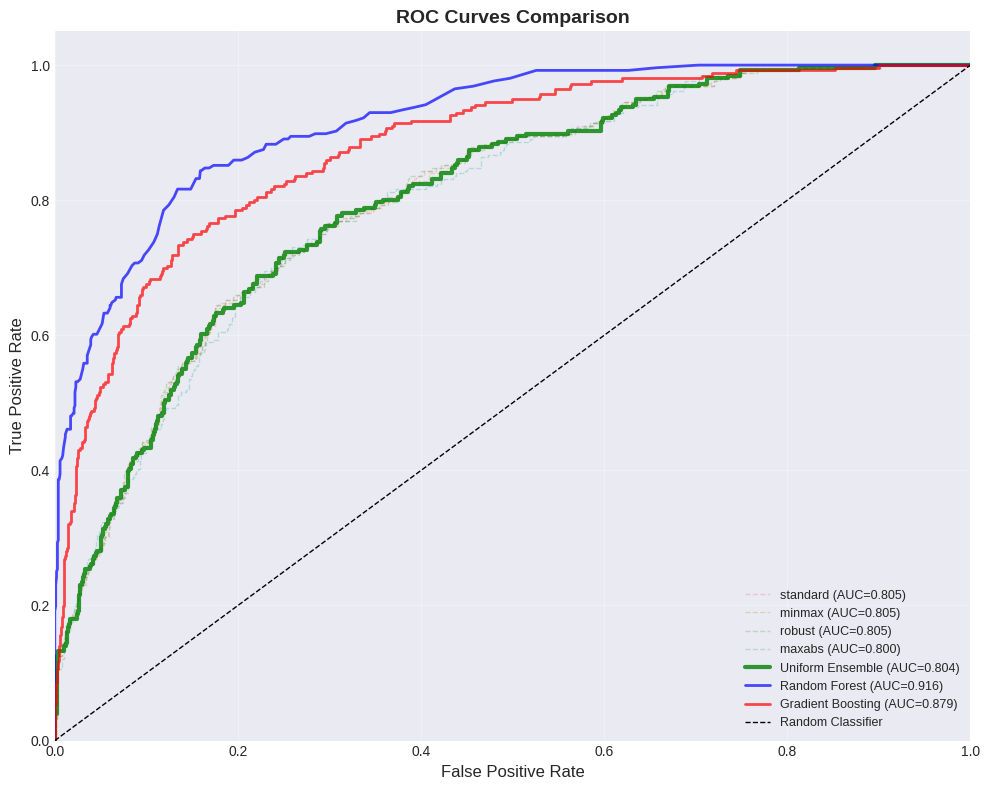

✓ ROC curves saved to ../results/ensemble/figures/roc_curves_comparison.png


In [22]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(10, 8))

# Plot individual scalers
for scaler_name, proba in member_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, proba[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, alpha=0.3, linestyle='--', linewidth=1,
            label=f'{scaler_name} (AUC={roc_auc:.3f})')

# Plot ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_proba)
roc_auc_ens = auc(fpr_ens, tpr_ens)
ax.plot(fpr_ens, tpr_ens, 'g-', linewidth=3, alpha=0.8,
        label=f'Uniform Ensemble (AUC={roc_auc_ens:.3f})')

# Plot Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, 'b-', linewidth=2, alpha=0.7,
        label=f'Random Forest (AUC={roc_auc_rf:.3f})')

# Plot Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
ax.plot(fpr_gb, tpr_gb, 'r-', linewidth=2, alpha=0.7,
        label=f'Gradient Boosting (AUC={roc_auc_gb:.3f})')

# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'roc_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ ROC curves saved to {save_path}")

### 6.2 Precision-Recall Curves

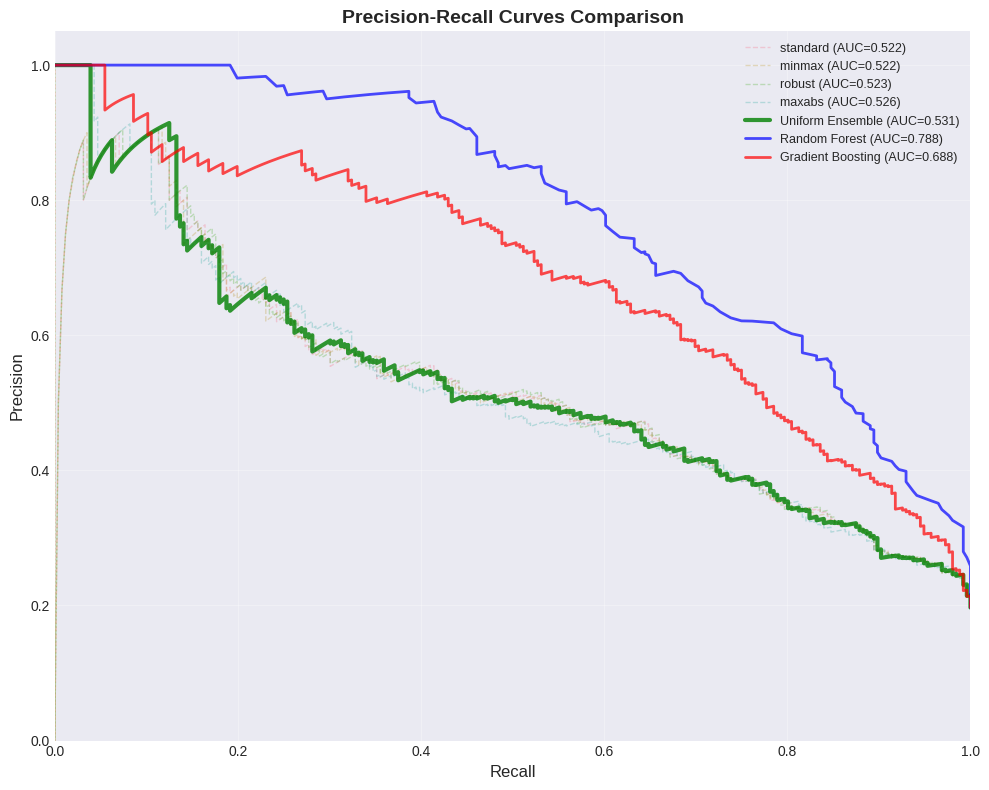

✓ Precision-Recall curves saved to ../results/ensemble/figures/precision_recall_curves_comparison.png


In [23]:
from sklearn.metrics import precision_recall_curve, auc as pr_auc_calc

fig, ax = plt.subplots(figsize=(10, 8))

# Plot individual scalers
for scaler_name, proba in member_predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, proba[:, 1])
    pr_auc = pr_auc_calc(recall, precision)
    ax.plot(recall, precision, alpha=0.3, linestyle='--', linewidth=1,
            label=f'{scaler_name} (AUC={pr_auc:.3f})')

# Plot ensemble
precision_ens, recall_ens, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc_ens = pr_auc_calc(recall_ens, precision_ens)
ax.plot(recall_ens, precision_ens, 'g-', linewidth=3, alpha=0.8,
        label=f'Uniform Ensemble (AUC={pr_auc_ens:.3f})')

# Plot Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc_rf = pr_auc_calc(recall_rf, precision_rf)
ax.plot(recall_rf, precision_rf, 'b-', linewidth=2, alpha=0.7,
        label=f'Random Forest (AUC={pr_auc_rf:.3f})')

# Plot Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_proba_gb)
pr_auc_gb = pr_auc_calc(recall_gb, precision_gb)
ax.plot(recall_gb, precision_gb, 'r-', linewidth=2, alpha=0.7,
        label=f'Gradient Boosting (AUC={pr_auc_gb:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'precision_recall_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Precision-Recall curves saved to {save_path}")

## 7. Validation Set Weight Search (Optional)

This section implements a grid search over possible weight combinations to find empirically optimal weights. This will be compared with Student 3's theoretical adaptive weights.

In [24]:
# Split training data into train/validation
from sklearn.model_selection import train_test_split

RUN_WEIGHT_SEARCH = True  # Set to False to skip

if RUN_WEIGHT_SEARCH:
    # Split training data
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
    )
    
    print(f"Validation set created:")
    print(f"  Training subset: {X_train_sub.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
else:
    print("Weight search skipped (set RUN_WEIGHT_SEARCH=True to enable)")

Validation set created:
  Training subset: 4157 samples
  Validation: 1040 samples


In [25]:
# Implement grid search over weights
if RUN_WEIGHT_SEARCH:
    print("\nSearching for optimal weights...")
    print("="*80)
    
    # Train ensemble on training subset
    val_ensemble = ScalingEnsemble(
        weights='uniform',
        cv=5,
        random_state=RANDOM_STATE,
        verbose=False
    )
    val_ensemble.fit(X_train_sub, y_train_sub)
    
    # Get individual predictions on validation set
    val_predictions = val_ensemble.get_member_predictions(X_val)
    
    # Create prediction matrix (n_samples x n_models)
    pred_matrix = np.column_stack([
        proba[:, 1] for proba in val_predictions.values()
    ])
    
    # Grid search over weights
    from itertools import product
    
    # Define weight grid (coarse grid for efficiency)
    weight_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    
    best_auc = 0
    best_weights = None
    
    # Generate weight combinations that sum to 1
    search_results = []
    n_models = len(val_ensemble.scalers_)
    
    # Simplified search: only try a subset of combinations
    print(f"Trying weight combinations (this may take a while)...")
    
    count = 0
    for w1 in weight_values:
        for w2 in weight_values:
            for w3 in weight_values:
                w4 = 1.0 - w1 - w2 - w3
                
                # Check if valid weight combination
                if w4 >= 0 and w4 <= 1:
                    weights = np.array([w1, w2, w3, w4])
                    
                    # Compute weighted prediction
                    y_pred_weighted = pred_matrix @ weights
                    
                    # Evaluate on validation set
                    val_auc = roc_auc_score(y_val, y_pred_weighted)
                    
                    search_results.append({
                        'weights': weights.tolist(),
                        'auc_roc': val_auc
                    })
                    
                    if val_auc > best_auc:
                        best_auc = val_auc
                        best_weights = weights
                    
                    count += 1
    
    print(f"✓ Searched {count} weight combinations")
    print(f"\nBest weights found (by validation AUC):")
    for scaler, weight in zip(val_ensemble.scalers_, best_weights):
        print(f"  {scaler:15s}: {weight:.3f}")
    print(f"\nValidation AUC: {best_auc:.4f}")
    
    # Evaluate on test set with optimal weights
    test_ensemble = ScalingEnsemble(
        weights=best_weights,
        cv=5,
        random_state=RANDOM_STATE,
        verbose=False
    )
    test_ensemble.fit(X_train, y_train)
    
    y_pred_optimal = test_ensemble.predict_proba(X_test)[:, 1]
    optimal_test_auc = roc_auc_score(y_test, y_pred_optimal)
    
    print(f"Test AUC with optimal weights: {optimal_test_auc:.4f}")
    print(f"Test AUC with uniform weights: {uniform_results['auc_roc']:.4f}")
    print(f"Improvement: {optimal_test_auc - uniform_results['auc_roc']:.4f}")
    
    print("="*80)


Searching for optimal weights...
Trying weight combinations (this may take a while)...
✓ Searched 173 weight combinations

Best weights found (by validation AUC):
  standard       : 0.000
  minmax         : 0.000
  robust         : 0.000
  maxabs         : 1.000

Validation AUC: 0.8112
Test AUC with optimal weights: 0.8003
Test AUC with uniform weights: 0.8041
Improvement: -0.0039


## 8. Save Results

In [26]:
# Save performance comparison
comparison_path = RESULTS_DIR / 'performance_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Performance comparison saved to {comparison_path}")

# Save training times separately
training_times_df = comparison_df[['model', 'training_time']].copy()
training_times_path = RESULTS_DIR / 'training_times.csv'
training_times_df.to_csv(training_times_path, index=False)
print(f"✓ Training times saved to {training_times_path}")

✓ Performance comparison saved to ../results/ensemble/performance_comparison.csv
✓ Training times saved to ../results/ensemble/training_times.csv


In [27]:
# Save diversity metrics
diversity_df = pd.DataFrame({
    'metric': ['avg_correlation', 'avg_disagreement', 'avg_prediction_variance'],
    'value': [
        avg_correlation,
        avg_disagreement,
        diversity_metrics['prediction_variance'].mean()
    ]
})

diversity_path = RESULTS_DIR / 'diversity_metrics.csv'
diversity_df.to_csv(diversity_path, index=False)
print(f"✓ Diversity metrics saved to {diversity_path}")

# Save correlation matrix
corr_path = RESULTS_DIR / 'pairwise_correlations.csv'
corr_df.to_csv(corr_path, index=True)
print(f"✓ Pairwise correlations saved to {corr_path}")

✓ Diversity metrics saved to ../results/ensemble/diversity_metrics.csv
✓ Pairwise correlations saved to ../results/ensemble/pairwise_correlations.csv


In [28]:
# Save optimal weights if search was run
if RUN_WEIGHT_SEARCH:
    scaler_names = list(val_ensemble.scalers_.keys())
    optimal_weights_df = pd.DataFrame({
        'scaler': scaler_names,
        'optimal_weight': best_weights,
        'uniform_weight': [1/len(scaler_names)] * len(scaler_names)
    })
    
    weights_path = RESULTS_DIR / 'optimal_weights.csv'
    optimal_weights_df.to_csv(weights_path, index=False)
    print(f"✓ Optimal weights saved to {weights_path}")

✓ Optimal weights saved to ../results/ensemble/optimal_weights.csv
